In [1]:
import sys
sys.path.append('/home/xinyiz/pamrats')

In [2]:
##This is adapted from https://github.com/tkipf/gae/blob/master/gae/train.py and https://github.com/tkipf/pygcn/blob/master/pygcn/train.py##

import time
import os

# Train on CPU (hide GPU) due to memory constraints
# os.environ['CUDA_VISIBLE_DEVICES'] = ""

import scanpy
import numpy as np
import scipy.sparse as sp

import torch
from torch import optim
from torch.utils.data import DataLoader
# from sklearn.metrics import roc_auc_score
# from sklearn.metrics import average_precision_score

import image.loadImage as loadImage
import gae.gae.optimizer as optimizer
import image.modelsCNN as modelsCNN

import pickle
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd


In [3]:
# Settings
os.environ["CUDA_VISIBLE_DEVICES"] = "0" 
use_cuda=True
fastmode=False #Validate during training pass
seed=3
epochs=1000
saveFreq=10
lr=0.00001 #initial learning rate
lr_adv=0.001
weight_decay=0 #Weight for L2 loss on embedding matrix.

batchsize=16

dropout=0.01
testNodes=0.1 #fraction of total nodes for testing
valNodes=0.05 #fraction of total nodes for validation
# randFeatureSubset=None
model_str='alexnet'

kernel_size=4
stride=2
padding=1

hidden1=64 #Number of channels in hidden layer 1
hidden2=128 
hidden3=256
hidden4=512
hidden5=512
fc_dim1=512*25*25
fc_dim2=1024

pretrainedAE=None #{'name':'controlphy5XAbin_01_dca','epoch':9990}
# training_samples=['control13','disease13','disease8','control8']
training_samples=['disease13']
targetBatch=None
switchFreq=10
diamThresh_mul=800
minThresh_mul=12
overlap=int(diamThresh_mul*0.7)
areaThresh=diamThresh_mul*diamThresh_mul*0.7
name='disease13_thresh25min12_overlap70area70_04'
logsavepath='/mnt/external_ssd/xinyi/log/train_cnnClf_starmap/'+name
modelsavepath='/mnt/external_ssd/xinyi/models/train_cnnClf_starmap/'+name
plotsavepath='/mnt/external_ssd/xinyi/plots/train_cnnClf_starmap/'+name

#Load data
sampleidx={'disease13':'AD_mouse9494','control13':'AD_mouse9498','disease8':'AD_mouse9723','control8':'AD_mouse9735'}
datadir='/home/xinyiz/2021-01-13-mAD-test-dataset'

# Set cuda and seed
np.random.seed(seed)
if use_cuda and (not torch.cuda.is_available()):
    print('cuda not available')
    use_cuda=False
torch.manual_seed(seed)
if use_cuda:
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.enabled = True

# Load data
# if randFeatureSubset != None:
#     idx=np.random.choice(features.shape[1],randFeatureSubset,replace=False)
#     features=features[:,idx]


In [4]:
plaqueCentroids={}
plaqueCentroids['disease13']=pd.read_csv('/home/xinyiz/2021-01-13-mAD-test-dataset/AD_mouse9494/trimmed_images/PlaqueMask3.csv', header=0)
plaqueCentroids['disease8']=pd.read_csv('/home/xinyiz/2021-01-13-mAD-test-dataset/AD_mouse9723/trimmed_images/PlaqueMask3.csv', header=0)
maxArea=max(np.max(plaqueCentroids['disease13']['Area']),np.max(plaqueCentroids['disease8']['Area']))
plaqueCutoffRadius=max(int(np.sqrt(maxArea)/2),int(diamThresh_mul/2))

In [5]:
imageslist={}
for s in ['disease13','disease8']:
    imageslist[s]=loadImage.loadandsplitPlaque_overlap(areaThresh,plaqueCentroids[s][['Y','X']].to_numpy().astype(int),plaqueCutoffRadius,sampleidx[s],datadir,diamThresh_mul,overlap,valNodes,testNodes,ifFlip=False,minCutoff=minThresh_mul,seed=seed,returnPos=True)
    

(22210, 22344)
plaque1385
no plaque3233
(22294, 19552)
plaque397
no plaque4563


In [6]:
for s in ['control13','control8']:
    imageslist[s]=loadImage.loadandsplit(sampleidx[s],datadir,diamThresh_mul,0,valNodes,testNodes,ifFlip=False,minCutoff=minThresh_mul,seed=seed,clf=True,returnPos=True)
    

(22355, 18953)
no cells
no cells
(22452, 19616)


In [7]:
if not os.path.exists(logsavepath):
    os.mkdir(logsavepath)
if not os.path.exists(modelsavepath):
    os.mkdir(modelsavepath)
if not os.path.exists(plotsavepath):
    os.mkdir(plotsavepath)

In [8]:
npos=0
nneg=0
for s in training_samples:
    npos=np.sum(imageslist['disease13'][3])
    nneg=imageslist['disease13'][3].shape[0]-npos
print(npos)
print(nneg)

1173
2752


In [10]:
mse=torch.nn.MSELoss()
# mse=torch.nn.MSELoss(reduction=None)
# Create model
if model_str=='alexnet':
    model = modelsCNN.AlexNet(2)
    lossCE=torch.nn.CrossEntropyLoss(torch.tensor([(nneg+npos)/nneg,(nneg+npos)/npos]).cuda().float())

# if model_str=='cnnvae_clf':
#     model = modelsCNN.CNN_VAE_clf(kernel_size, stride, padding, 1, hidden1, hidden2, hidden3, hidden4, hidden5, fc_dim1,fc_dim2)
#     lossCE=torch.nn.CrossEntropyLoss(torch.tensor([1,imageslist['disease13'][3].shape[0]/np.sum(imageslist['disease13'][3])]).cuda().float())

if use_cuda:
    model.cuda()
    
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)


In [11]:
# model.load_state_dict(torch.load(os.path.join(modelsavepath,str(9360)+'.pt')))
# epochs=20000
if pretrainedAE:
    print('loading '+pretrainedAE['name']+' epoch '+str(pretrainedAE['epoch']))
    model.load_state_dict(torch.load(os.path.join('/mnt/xinyi/pamrats/models/train_gae_starmap/'+pretrainedAE['name'],str(pretrainedAE['epoch'])+'.pt')))
    
def train(epoch):
    t = time.time()
    model.train()
    
    loss_all=0
    for i in range(int(np.ceil(trainInputnp.shape[0]/batchsize))):
        
        trainInput=trainInputnp[i*batchsize:min((i+1)*batchsize,trainInputnp.shape[0])]
        labels=trainLabelsnp[i*batchsize:min((i+1)*batchsize,trainInputnp.shape[0])]
        if use_cuda:
            trainInput=torch.tensor(trainInput).cuda().float()
            labels=torch.tensor(labels).cuda().long()
        optimizer.zero_grad()

        pred = model(trainInput)


        loss=lossCE(pred,labels)
        loss_all+=loss.item()
        
        loss.backward()
        optimizer.step()

    loss_all=loss_all/trainInputnp.shape[0]
    
    model.eval()
    loss_val_all=0
    for i in range(int(np.ceil(valInputnp.shape[0]/batchsize))):
        valInput=valInputnp[i*batchsize:min((i+1)*batchsize,valInputnp.shape[0])]
        labels=valLabelsnp[i*batchsize:min((i+1)*batchsize,valInputnp.shape[0])]
        if use_cuda:
            valInput=torch.tensor(valInput).cuda().float()
            labels=torch.tensor(labels).cuda().long()
        pred = model(valInput)

        loss_val_all+=lossCE(pred,labels).item()

    loss_val_all=loss_val_all/valInputnp.shape[0]
    
    print(training_samples_t+' Epoch: {:04d}'.format(epoch),
          'loss_train: {:.4f}'.format(loss_all),
          'loss_val: {:.4f}'.format(loss_val_all))
    return loss_all,loss_val_all
    
train_loss_ep=[None]*epochs
val_loss_ep=[None]*epochs
t_ep=time.time()

for ep in range(epochs):
# for ep in range(10000,20000):
    t=int(ep/switchFreq)%len(training_samples)
    training_samples_t=training_samples[t]
    
    trainInputnp, valInputnp, _,trainLabelsnp,valLabelsnp,_,_,_,_=imageslist[training_samples_t]
    
#     trainInputloader=DataLoader(zip(trainInputnp,trainLabelsnp), batch_size=batchsize, drop_last=False, shuffle=False)
#     valInputloader=DataLoader(zip(valInputnp,valLabelsnp), batch_size=batchsize, drop_last=False, shuffle=False)
    
    
    train_loss_ep[ep],val_loss_ep[ep]=train(ep)

        
    if ep%saveFreq == 0:
        torch.save(model.cpu().state_dict(), os.path.join(modelsavepath,str(ep)+'.pt'))
    if use_cuda:
        model.cuda()
        torch.cuda.empty_cache()
print(' total time: {:.4f}s'.format(time.time() - t_ep))


disease13 Epoch: 0000 loss_train: 0.0432 loss_val: 0.0441
disease13 Epoch: 0001 loss_train: 0.0429 loss_val: 0.0428
disease13 Epoch: 0002 loss_train: 0.0409 loss_val: 0.0401
disease13 Epoch: 0003 loss_train: 0.0380 loss_val: 0.0383
disease13 Epoch: 0004 loss_train: 0.0356 loss_val: 0.0364
disease13 Epoch: 0005 loss_train: 0.0353 loss_val: 0.0353
disease13 Epoch: 0006 loss_train: 0.0350 loss_val: 0.0349
disease13 Epoch: 0007 loss_train: 0.0350 loss_val: 0.0346
disease13 Epoch: 0008 loss_train: 0.0348 loss_val: 0.0344
disease13 Epoch: 0009 loss_train: 0.0348 loss_val: 0.0344
disease13 Epoch: 0010 loss_train: 0.0346 loss_val: 0.0344
disease13 Epoch: 0011 loss_train: 0.0346 loss_val: 0.0343
disease13 Epoch: 0012 loss_train: 0.0344 loss_val: 0.0343
disease13 Epoch: 0013 loss_train: 0.0345 loss_val: 0.0342
disease13 Epoch: 0014 loss_train: 0.0344 loss_val: 0.0341
disease13 Epoch: 0015 loss_train: 0.0343 loss_val: 0.0341
disease13 Epoch: 0016 loss_train: 0.0342 loss_val: 0.0340
disease13 Epoc

KeyboardInterrupt: 

In [12]:
# with open(os.path.join(logsavepath,'train_loss'), 'rb') as input:
#     train_loss_ep[:9360]=pickle.load(input)
# with open(os.path.join(logsavepath,'train_loss_kl'), 'rb') as input:
#     train_loss_kl_ep[:9360]=pickle.load(input)
# with open(os.path.join(logsavepath,'train_loss_x'), 'rb') as input:
#     train_loss_x_ep[:9360]=pickle.load(input)
# with open(os.path.join(logsavepath,'train_loss_a'), 'rb') as input:
#     train_loss_a_ep[:9360]=pickle.load(input)
# with open(os.path.join(logsavepath,'val_loss'), 'rb') as input:
#     val_loss_ep[:9360]=pickle.load(input)
# with open(os.path.join(logsavepath,'val_loss_x'), 'rb') as input:
#     val_loss_x_ep[:9360]=pickle.load(input)
# with open(os.path.join(logsavepath,'val_loss_a'), 'rb') as input:
#     val_loss_a_ep[:9360]=pickle.load(input)
# with open(os.path.join(logsavepath,'train_loss_adv'), 'rb') as input:
#     train_loss_adv_ep[:9360]=pickle.load(input)
# with open(os.path.join(logsavepath,'val_loss_adv'), 'rb') as input:
#     val_loss_adv_ep[:9360]=pickle.load(input)
# with open(os.path.join(logsavepath,'train_loss_advD'), 'rb') as input:
#     train_loss_advD_ep[:9360]=pickle.load(input)
# with open(os.path.join(logsavepath,'val_loss_advD'), 'rb') as input:
#     val_loss_advD_ep[:9360]=pickle.load(input)
    
with open(os.path.join(logsavepath,'train_loss'), 'wb') as output:
    pickle.dump(train_loss_ep, output, pickle.HIGHEST_PROTOCOL)
with open(os.path.join(logsavepath,'val_loss_x'), 'wb') as output:
    pickle.dump(val_loss_ep, output, pickle.HIGHEST_PROTOCOL)


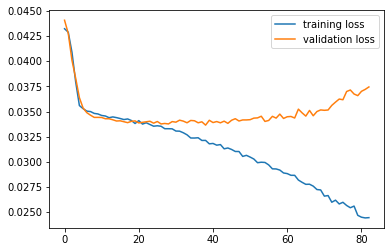

In [13]:
plt.plot(np.arange(epochs),train_loss_ep)
plt.plot(np.arange(epochs),val_loss_ep)
# plt.ylim((0,0.01))
# plt.xlim((0,3000))
plt.legend(['training loss','validation loss','training kl loss','training discriminator ae','validation discriminator ae','training discriminator d','validation discriminator d'],loc='upper right')
plt.savefig(os.path.join(plotsavepath,'loss_seed3.jpg'))
plt.show()


In [14]:
# name='c13k20XA_07_dca'
# logsavepath='/mnt/xinyi/pamrats/log/train_gae_starmap/'+name
# with open(os.path.join(logsavepath,'val_loss_a'), 'rb') as output:
#     val_loss_a_ep=pickle.load(output)
np.argmin(val_loss_ep[:80])
# np.where(np.logical_not(np.isfinite(val_loss_ep[:])))
# val_loss_a_ep[8700]

38

In [19]:
testepoch=40
model.load_state_dict(torch.load(os.path.join(modelsavepath,str(testepoch)+'.pt')))
model.eval()
for s in sampleidx.keys():
# for s in ['disease13']:
    print(s)
    _,_, testInputnp,_,_,testLabelsnp,_,_,_=imageslist[s]
    
    testInputloader=DataLoader(testInputnp, batch_size=batchsize, drop_last=False, shuffle=False)
    
    loss_test_all=0
    for i in range(int(np.ceil(testInputnp.shape[0]/batchsize))):
        testInput=testInputnp[i*batchsize:min((i+1)*batchsize,testInputnp.shape[0])]
        labels=testLabelsnp[i*batchsize:min((i+1)*batchsize,testInputnp.shape[0])]
        if use_cuda:
            testInput=torch.tensor(testInput).cuda().float()
            labels=torch.tensor(labels).cuda().long()
        pred = model(testInput)

        loss_test_all+=lossCE(pred,labels).item()

    loss_test_all=loss_test_all/testInputnp.shape[0]
    
        
    print('test results',
          'loss_x_test: {:.4f}'.format(loss_test_all))
#          'loss_adv_test: {:.4f}'.format(loss_adv_test.item()))
   

disease13
test results loss_x_test: 0.0289


In [11]:
def plotExprs(exprs,exprs2,savename,embedding,embedding2,savepath,savenameAdd=''):
#     fig, ax = plt.subplots(dpi=400)
    if not exprs is None:
        plt.scatter(embedding[:,0],embedding[:,1],c=exprs,cmap='Greys',edgecolors='blue',linewidth=1,alpha=1,marker='o',vmin=0,vmax=4)
    if not exprs2 is None:
        plt.scatter(embedding2[:,0],embedding2[:,1],c=exprs2,cmap='Greys',edgecolors='green',linewidth=1,alpha=1,marker='^',vmin=0,vmax=4)
    plt.colorbar(orientation='vertical', shrink = 0.5)
    plt.gca().set_aspect('equal', 'datalim')
#     fig.set_figheight(5)
#     fig.set_figwidth(5)
    plt.savefig(os.path.join(savepath,savename+savenameAdd+'.jpg'),dpi=400)
#     plt.show()
    
#     fig.clf()
    plt.close('all')

In [ ]:
def plotLoss(inputNp,labelsNp,coordNp,name,savenameAdd=''):
    loss_test_all=np.zeros(inputNp.shape[0])
    for i in range(inputNp.shape[0]):
        testInput=inputNp[[i]]
        labels=labelsNp[[i]]
        if use_cuda:
            testInput=torch.tensor(testInput).cuda().float()
            labels=torch.tensor(labels).cuda().long()
        pred = model(testInput)
        loss_test_all[i]=lossCE(pred,labels).item()
    
    posidx=labelsNp==1
    negidx=labelsNp==0
    loss_test_posLoss=np.sum(loss_test_all[posidx])/np.sum(posidx)
    loss_test_negLoss=np.sum(loss_test_all[negidx])/np.sum(negidx)
    print(name+' results',
          'loss positive: {:.4f}'.format(loss_test_posLoss),
         'loss negative: {:.4f}'.format(loss_test_negLoss))
    
    plotExprs(loss_test_all[posidx],loss_test_all[negidx],name+'loss'+s,coordNp[posidx],coordNp[negidx],plotsavepath,savenameAdd=savenameAdd)
    plotExprs(loss_test_all[posidx],None,name+'loss'+s+'_positive',coordNp[posidx],None,plotsavepath,savenameAdd=savenameAdd)
    plotExprs(None,loss_test_all[negidx],name+'loss'+s+'_negative',None,coordNp[negidx],plotsavepath,savenameAdd=savenameAdd)


# testepoch=20
# model.load_state_dict(torch.load(os.path.join(modelsavepath,str(testepoch)+'.pt')))
model.eval()
plotepoch='untrained'
for s in sampleidx.keys():
    print(s)
    trainInputnp, valInputnp, testInputnp, trainLabelsnp,valLabelsnp,testLabelsnp,trainCoordnp,valCoordnp,testCoordnp=imageslist[s]
    plotLoss(testInputnp,testLabelsnp,testCoordnp,'test',plotepoch)
    plotLoss(trainInputnp,trainLabelsnp,trainCoordnp,'train',plotepoch)
    plotLoss(valInputnp,valLabelsnp,valCoordnp,'val',plotepoch)
    plotLoss(np.concatenate((trainInputnp,valInputnp,testInputnp),axis=0),np.concatenate((trainLabelsnp,valLabelsnp,testLabelsnp)),np.concatenate((trainCoordnp,valCoordnp,testCoordnp),axis=0),'all',plotepoch)
    

disease13
test results loss positive: 0.6872 loss negative: 0.6991
train results loss positive: 0.6872 loss negative: 0.6991
val results loss positive: 0.6872 loss negative: 0.6991


In [11]:
pred.shape

torch.Size([1, 2])

In [15]:
labels=testLabelsnp[i]

In [16]:
labels

1

In [ ]:
torch.sum(result[zeroidx])

In [ ]:
# model.pi.weight[:8,:8]
model_str